# Exercises Lecture 4: Classification 

In this session, you will learn to extract features and perform classification as discussed in the lecture.

* Extract raw count features based on the words present in a document
* Normalize raw counts using TF-IDF transformation
* Learn a classifier on training data 
* Tune the model using Grid search
* Evaluate a classifier using various metrics on test data
* Compare several classifiers performance
* Investigate features: finding the most predictive ones
* Investigate features: comparing several feature sets, concatenating different features

We'll use what we learned from the previous lectures: especially, we'll use some pre-processing to improve the performance of our systems, and we'll also use some vizualisation tools.

The practical session is organized as follow:

* **Part 0 - Code given**: describes some functions already implemented for you
* **Part 1 - Vectorizing**: using a single example, we'll see how to transform a text into a vector.
* **Part 2 - Classifying**: using an artificial set of examples, we'll manipulate classifier object to get a better understanding of machine learning problems.
* **Part 3 - Playing with real data**: using IMDB data, we'll investigate a real machine learning problem, namely classifying movies as comedy or drama, and comparing different algorithms, sets of features and values for the hyper-parameters. 

This practical session focuses on (binary) classification, as an introduction to Machine Learning. But one we'll be familiar with the scikit library, we'll se that it is easy to try and play with other machine learning settings, such as multiclass classification, clustering and regression. Some suggestions are given at the end. 

Python library used: scikit-learn v21.2

### Preliminaries

#### Installing scikit-learn

Note that sklearn is known as a fast evolving library, deliberately unstable: when upgrading, the developers do not try to keep compatibility with older versions, which allows to make drastic change in the library, for example to make it easier to use. In return, the code you write now could be broken with future versions of scikit: that's why it's crucial to keep track of which version you used when developing your code! Conda virtual environments provide an easy way to run your code with an old version of any library. 

https://scikit-learn.org/stable/install.html

* If you're using anaconda: in your terminal, do **conda install scikit-learn**

It'll install the latest version of scikit-learn (that is 21.2 as for today). Recommended, as it'll check for all dependencies needed. In particular, you'll need numpy and scipy.

* Alteratively, you can use pip: pip install -U scikit-learn

#### Using scikit-learn (or *sklearn*)

Scikit comes with nice tutorials: https://scikit-learn.org/stable/tutorial/index.html.

It's very important to be able to go through the API and understand how to read and use it. For each exercise, read the documentation to become familiar with it, it will allow you to be able to use, in the future, other functions than the ones used in this practical session: https://scikit-learn.org/stable/modules/classes.html.

To use scikit-learn, the *import* module name is *sklearn*.


## Part 0 - Code given

Some useful functions are given in the file *utils_04.py*, they'll allow you to read the data and perform a few more things. Also the path to the data used is given below, change it accordingly to your need.

#### Data

In the next cell, *path_to_data* and *path_to_preprocess* are variables corresponding to the path to the data we're going to use.

If it doesn't work, then you're not at the right place:

```
>>> conda activate anaconda/env/python4nlp
>>> cd python4nlp-2019/notebooks/
>>> jupyter notebook
```

In [3]:
import os

## Used in Part 1: 500  movies
path_to_data = '../data/movies_500.csv'
#path_to_preprocess = 'data/l2/'
#path_to_pp_sentences = os.path.join( path_to_preprocess, 'postags/' )
path_to_postags = os.path.join( '../data/postags/' )

## Used in Part 3: 10 000 movies filtered, ie. only comedies and drama
path_to_data_filtered = '../data/preprocess_movies_10000_filtered/movies_10000_comedy-drama.csv'
path_to_postags_filtered = '../data/preprocess_movies_10000_filtered/postags/'

#### Utils functions

Some functions are already implemented to help you focus on the more important parts of the code. You can read the code in *utils_04.py* if needed. Below are exemples of use of the reading functions.

In [4]:
from utils_04 import *

# movies is a list of dictionnaries, each dict contains all the info about the movie
movies = read_data( path_to_data )
print( movies[0] )

# of movies: 500
Categories: id, title, year, director, story, actors, genres, countries, rating, voters, gross
{'id': 'tt1431045', 'title': 'Deadpool', 'year': 2016, 'director': 'Tim Miller', 'story': 'This is the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, adopts the alter ego Deadpool. Armed with his new abilities and a dark, twisted sense of humor, Deadpool hunts down the man who nearly destroyed his life.', 'actors': ['Ryan_Reynolds', 'Morena_Baccarin', 'TJ_Miller'], 'genres': ['Action', 'Adventure', 'Comedy', 'Sci-Fi'], 'countries': ['USA'], 'rating': 8.0, 'voters': 826748, 'gross': 132434639}


In [5]:
# postags is a dictionnary: movie id --> list of triplets (token, lemma, pos)
postags = read_postags( path_to_postags )
print( postags['tt1431045'] )
print()
# We add the information from postags files to the movies dictionnary at the key 'tok_lem_pos'
merge_movies( movies, postags )
print( movies[0] )

[('this', 'this', 'DT'), ('is', 'be', 'VBZ'), ('the', 'the', 'DT'), ('origin', 'origin', 'JJ'), ('story', 'story', 'NN'), ('of', 'of', 'IN'), ('former', 'former', 'JJ'), ('special', 'special', 'JJ'), ('forces', 'force', 'NNS'), ('operative', 'operative', 'JJ'), ('turned', 'turn', 'VBD'), ('mercenary', 'mercenary', 'JJ'), ('wade', 'wade', 'NN'), ('wilson', 'wilson', 'NN'), ('who', 'who', 'WP'), ('after', 'after', 'IN'), ('being', 'be', 'VBG'), ('subjected', 'subject', 'VBN'), ('to', 'to', 'TO'), ('a', 'a', 'DT'), ('rogue', 'rogue', 'NN'), ('experiment', 'experiment', 'NN'), ('that', 'that', 'WDT'), ('leaves', 'leave', 'VBZ'), ('him', 'him', 'PRP'), ('with', 'with', 'IN'), ('accelerated', 'accelerate', 'VBN'), ('healing', 'heal', 'VBG'), ('powers', 'power', 'NNS'), ('adopts', 'adopt', 'VBP'), ('the', 'the', 'DT'), ('alter', 'alter', 'NN'), ('ego', 'ego', 'NN'), ('deadpool', 'deadpool', 'NN'), ('armed', 'arm', 'VBN'), ('with', 'with', 'IN'), ('his', 'his', 'PRP$'), ('new', 'new', 'JJ'), (

## Part 1: Vectorizing data

In this exercise, we're going to transform 1 text to a bag-of-word representation. To do that, we'll use a class called *CountVectorizer* from the module *sklearn.feature_extraction.text*: 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

### Exercise 1.1 Raw counts

1. Put the text of the first movie story into a list, because *CountVectorizer* takes as input a list of instances to be transformed (see the doc). Name the list *instances*.
2. Vectorize this instance: i.e. transform the instances (here, only 1 instance/text) into a matrix **X** (here, containing only 1 row)
    1. create an object *CountVectorizer* 
    2. then apply the *fit_transform()* function to **X**
3. Print the original text of the instance (the story of the movie).
4. Print the shape of output matrix **X** (*X.shape*) and then, print the whole matrix (hint: print *X.toarray()* and not just *X* to get a dense matrix rather than a sparse one, more readable)
5. Each *Vectorizer* object is associated with a vocabulary, i.e. a dictionnary whose keys are the unique features appearing in the input data and the values are the indices of each feature in the output matrix. You can retrieve this vocabulary using: *my_vectorizer.vocabulary_*
    1. Print the assiocated vocabulary size
    2. Print the entire vocabulary
    3. Print the sorted vocabulary using *sort_dict(my_dictionnary)*, a function implemented in *utils_04.py*. The elements are sorted by values (here, the indices), it's easier to read. 
    ```
    print( sort_dict(my_dictionnary) )
    ```

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Put the text of the first story into a list named instances
instances = [movies[0]['story']]
# 2.A. Create a CountVectorizer instance named my_vectorizer
my_vectorizer = CountVectorizer()
# 2.B. Apply it to the list, using the method fit_transform() to output the matrix named X
X = my_vectorizer.fit_transform( instances )

# 3. Print the original text of the instance 
print( instances[0], '\n' )
# 4. Print the shape of X using X.shape and the whole matrix X using X.toarray()
print( 'X shape:', X.shape )
print( X.toarray(), '\n' )
# 5.A. Print the vocabulary size
print( "Vocabulary size:", len(my_vectorizer.vocabulary_) )
# 5.B. Print the entire vocabulary
print( my_vectorizer.vocabulary_, '\n' )
# 5.C. Print the sorted vocabulary using sort_dict(my_dictionnary)
print( sort_dict( my_vectorizer.vocabulary_ ) )


This is the origin story of former Special Forces operative turned mercenary Wade Wilson, who after being subjected to a rogue experiment that leaves him with accelerated healing powers, adopts the alter ego Deadpool. Armed with his new abilities and a dark, twisted sense of humor, Deadpool hunts down the man who nearly destroyed his life. 

X shape: (1, 47)
[[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
  1 1 3 1 1 1 1 1 2 1 2]] 

Vocabulary size: 47
{'this': 39, 'is': 21, 'the': 38, 'origin': 30, 'story': 35, 'of': 28, 'former': 15, 'special': 34, 'forces': 14, 'operative': 29, 'turned': 41, 'mercenary': 25, 'wade': 43, 'wilson': 45, 'who': 44, 'after': 3, 'being': 7, 'subjected': 36, 'to': 40, 'rogue': 32, 'experiment': 13, 'that': 37, 'leaves': 22, 'him': 17, 'with': 46, 'accelerated': 1, 'healing': 16, 'powers': 31, 'adopts': 2, 'alter': 4, 'ego': 12, 'deadpool': 9, 'armed': 6, 'his': 18, 'new': 27, 'abilities': 0, 'and': 5, 'dark': 8, 'twisted': 42, 'se

**Results:** 

* You should see that your original set of instances is now represented by a matrix. 
    * A matrix in python looks like a list of list. e.g. a 3x4 matrix (3 rows, 4 columns) would look like: [[1,2,0,1],[2,1,4,2],[1,2,1,2]]
    * Here *X.shape* should return *(1,47)*: 1 row and 47 columns
* Here, we have only 1 instance, thus the matrix contains only 1 row vector. The rows are the instances, the columns are the features: here, we have 47 columns corresponding to the size of the vocabulary.
* This vector contains numbers like 1, 2 or 3. These numbers represent the frequency of each associated word/feature.
* The indices in this vector allow to retrieve the associated word/feature in the vocabulary:
    * For example, the first 1 in the vector means that the word 'abilities' appears once in the text. The last number in the vector is a 2, because 'with' appears twice in the text.

### Exercise 1.2: TF-IDF transformation

Normalize the raw counts using TF-IDF:

1. Use TfidfTransformer to normalize the matrix **X** of raw counts:
    1. create an object *TfidfTransformer*
    2. apply the *fit_transform()* method to transform the original matrix **X**
2. Print the new matrix

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

# 1.A. Create an instance of TfidfTranformer
my_transformer = TfidfTransformer()
# 1.B. Learn and apply the transformer on X using the fit_transform() method
X = my_transformer.fit_transform( X )

# 2. Print the transformed X matrix
print( X.toarray() )

[[0.11952286 0.11952286 0.11952286 0.11952286 0.11952286 0.11952286
  0.11952286 0.11952286 0.11952286 0.23904572 0.11952286 0.11952286
  0.11952286 0.11952286 0.11952286 0.11952286 0.11952286 0.11952286
  0.23904572 0.11952286 0.11952286 0.11952286 0.11952286 0.11952286
  0.11952286 0.11952286 0.11952286 0.11952286 0.23904572 0.11952286
  0.11952286 0.11952286 0.11952286 0.11952286 0.11952286 0.11952286
  0.11952286 0.11952286 0.35856858 0.11952286 0.11952286 0.11952286
  0.11952286 0.11952286 0.23904572 0.11952286 0.23904572]]


**Result:**

* The raw counts have been transformed from integers to floats, all the 1s became 0.11952286, the 2s 0.23904572 etc.
* Here, using TF-IDF is not useful at all since we do not have a corpus that could be used to mitigate the impact of very frequent tokens.

### Exercise 1.3: Using actor names as features

Do the same as previously but using the names of the actors. We'll here focus on the first 10 movies.

```
# List of the first 10 movies
movies[:10]
```

1. First, compute the number of unique actors in the first 10 movies
2. The instances are now the names of the actors. Recall that *Vectorizer* takes a list of *String* as input: 
    1. Extract the list of the actor names for the first 10 movies
    2. Join each list of actors using space (this new string will be split on space by scikit vectorizer's functions):
```
>>> ' '.join( ['Ryan_Reynolds', 'Morena_Baccarin'] ) 
'Ryan_Reynolds Morena_Baccarin'
```
3. Vectorize these 10 instances using raw counts
4. Print the vocabulary size (*my_vectorizer.vocabulary_*)
5. Print the entire sorted vocabulary 
6. Print each instance and its associated vector

In [8]:
# 1. Compute the number of unique actors in the first 10 movies
actors = []
for m in movies[:10]:
    for a in m['actors']:
        if not a in actors:
            actors.append(a)
print( "# of unique actors (10 movies):", len(actors) )

# 2. Build the list of instances
instances = [' '.join( m['actors'] ) for m in movies[:10]]

# 3. Create an instance of CountVectorizer
my_vectorizer = CountVectorizer()
# Fit the vectorizer and tranform the instances
X = my_vectorizer.fit_transform( instances )

# 4. 5. Print the vocabulary size, and the entire dictionnary
print( "Vocabulary size:", len(my_vectorizer.vocabulary_) )
print( sort_dict(my_vectorizer.vocabulary_), '\n' )

# 6. Print the instances and their associated vector
for i in range( len(instances) ):
    print( i, instances[i] )
    print( X[i,:].toarray() )

# of unique actors (10 movies): 26
Vocabulary size: 26
[(0, 'amy_adams'), (1, 'ben_affleck'), (2, 'bryce_dallas_howard'), (3, 'chris_evans'), (4, 'chris_hemsworth'), (5, 'chris_pratt'), (6, 'dafne_keen'), (7, 'daisy_ridley'), (8, 'henry_cavill'), (9, 'hugh_jackman'), (10, 'jessica_chastain'), (11, 'john_boyega'), (12, 'kristen_wiig'), (13, 'leonardo_dicaprio'), (14, 'mark_ruffalo'), (15, 'matt_damon'), (16, 'morena_baccarin'), (17, 'oscar_isaac'), (18, 'patrick_stewart'), (19, 'robert_downey_jr'), (20, 'ryan_reynolds'), (21, 'scarlett_johansson'), (22, 'tj_miller'), (23, 'tom_hardy'), (24, 'ty_simpkins'), (25, 'will_poulter')] 

0 Ryan_Reynolds Morena_Baccarin TJ_Miller
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0]]
1 Daisy_Ridley John_Boyega Oscar_Isaac
[[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
2 Matt_Damon Jessica_Chastain Kristen_Wiig
[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]]
3 Robert_Downey_Jr Chris_Hemsworth Mark_Ruffalo
[[0 0 0 0 1 0 0 0 0 0 0

**Results:**

* The vocabulary size should be the same as the number of unique actors: it's exactly what's a feature set is, the list of unique attributes in your (training) data
* 6.: Print of instances and vectors:
    * Instances 4 and 6 should have two 1s at the same place since they share two actors, check with the vocabulary that everything seems alright.

### Exercise 1.4: *fit_transform()* vs *transform()*: train vs dev/test data

A set of feature is **always computed/learned/built on the training set**. Once a *Vectorizer* object is built on the train set, one has to use exactly the same *Vectorizer* object to vectorize the dev/test set.

It means that a system only *knows* about what appears in the training set: the vocabulary is built on the training set, every unknown words appearing in dev/test will be ignored.

In the following, we'll use the previously computed set of instances (first 10 movies) as training data, and the next 10 as evaluation data
```
# Evaluation data are movies between index 10 and 20
movies[10:20]
```

1. First, compute the number of unique actors in the first 20 movies
2. Take the 10 movies between indices 10 and 20 as test instances, and again, keep only the information about actors to build the list *instances_test*
3. Apply the previous *Vectorizer* object, built on the first 10 movies, to these new data, using the *transform()* function, and create the matrix **X_test**
4. Print the vocabulary size
5. Print the vocabulary
6. Print the test instances and the associated vectors

In [9]:
# 1. Compute the number of unique actors in the first 20 movies
actors = []
for m in movies[:20]:
    for a in m['actors']:
        if not a in actors:
            actors.append(a)
print( "# of unique actors (20 movies):", len(actors) )

# 2. Build the list of test instances from movies between indices 10 and 20
instances_test = [' '.join( m['actors'] ) for m in movies[10:20]]

# 3. Apply the vectorizer previously built to tranform the test instances (create matrix **X_test**)
X_test = my_vectorizer.transform( instances_test )

# 4. and 5. Print the vocabulary size, and the entire dictionnary
print( "Vocabulary size:", len(my_vectorizer.vocabulary_) )
print( sort_dict(my_vectorizer.vocabulary_), '\n' )

# 6. Print the test instances and associated vectors
for i in range( len(instances_test) ):
    print( i, instances_test[i] )
    print( X_test[i,:].toarray() )

# of unique actors (20 movies): 53
Vocabulary size: 26
[(0, 'amy_adams'), (1, 'ben_affleck'), (2, 'bryce_dallas_howard'), (3, 'chris_evans'), (4, 'chris_hemsworth'), (5, 'chris_pratt'), (6, 'dafne_keen'), (7, 'daisy_ridley'), (8, 'henry_cavill'), (9, 'hugh_jackman'), (10, 'jessica_chastain'), (11, 'john_boyega'), (12, 'kristen_wiig'), (13, 'leonardo_dicaprio'), (14, 'mark_ruffalo'), (15, 'matt_damon'), (16, 'morena_baccarin'), (17, 'oscar_isaac'), (18, 'patrick_stewart'), (19, 'robert_downey_jr'), (20, 'ryan_reynolds'), (21, 'scarlett_johansson'), (22, 'tj_miller'), (23, 'tom_hardy'), (24, 'ty_simpkins'), (25, 'will_poulter')] 

0 Amy_Poehler Bill_Hader Lewis_Black
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1 Will_Smith Jared_Leto Margot_Robbie
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
2 Chadwick_Boseman Michael_B_Jordan Lupita_Nyong'o
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
3 Benedict_Cumberbatch Chiwetel_Ejiofor Rachel_McAdams
[[0 0 0 0 0 0 

**Results:**

* 4 and 5.: The vocabulary dictionnary and the vocabulary size should be the same as in Exercise 1.3. The vocabulary is exactly the same as previously, we did not change it, it is built only using the training data. The *transform()* method uses this previously built dictionnary to vectorize the new data but new words appearing only in the evaluation set are ignored. They are called unknown words. 
    * Here, we have 53 actor names in total, but a vocabulary of size 26, thus a lot of unknown words!
* 6.: Note that we have vectors with many 0s, because the actor names of these instances do not appear in the first ten movies, thus they are not part of the vocabulary. A machine learning system can only learn from the training data, that's why we need our training data to be representative!

## Part 2: Classifying

We're now going to test a classifier on a (very very) small dataset. In the next cell, you'll find the training and test instances. The data are stored exactly as in *movies*, except we only consider genre et story. Of course, these are not real stories, but artificial data created to help understanding the behaviour of a classifier.

The classes are drama and comedy, the labels are defined as: **1 for drama, 0 for comedy**.

In this part, we're going to use a *Perceptron* classifier, a very simple linear classifier. You can read the documentation at:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron

In [10]:
instances_train = [
    {'genres':['drama'], 'story':"This is a very sad story, about suffering and pain, a lot of pain."},
    {'genres':['drama'], 'story':"This is another story, a very sad one. People suffers and, eventually, die."},
    {'genres':['comedy'], 'story':"This is a fun story, where people makes many jokes."},
    {'genres':['comedy'], 'story':"This is another fun story and you should laugh a lot."}
]
instances_test = [
    {'genres':['drama'], 'story':"Sally is sad and Harry tries to help her."},
    {'genres':['comedy'], 'story':"It could seem sad but in fact I'm just joking ang laughing a lot."}
]

tag_to_ix = {'drama':1, 'comedy':0}

print( "# Training instances:", len(instances_train) )
print( "# Test instances:", len(instances_test) )
print( "# Classes:", len(tag_to_ix) )

# Training instances: 4
# Test instances: 2
# Classes: 2


### Exercise 2.1: Vectorizing using raw counts

As previously, the stories are used to compute features. 

1. Create a new *Vectorizer* object
2. Apply the function *fit_transform()* to the training set (create the matrix **X_train**)
3. Apply the function *transform()* to the test set (create the matrix **X_test**)
4. Creates the lists **y_train** and **y_test** containing the labels of the instances (0 or 1 as defined)
5. Print the sorted vocabulary and its size
6. Print each instance with its label and its associated to the vector

In [11]:
# 1. 2. and 3. Vectorize the input data into: X_train and X_test
my_vectorizer = CountVectorizer()
X_train = my_vectorizer.fit_transform([m['story'] for m in instances_train])
X_test = my_vectorizer.transform([m['story'] for m in instances_test])

# 4. Create the list of labels: y_train and y_test 
y_train = [1 if 'drama' in m['genres'] else 0 for m in instances_train ]
y_test = [1 if 'drama' in m['genres'] else 0 for m in instances_test ]

# 5. Print the vocabulary
print( 'Vocabulary size:', len(my_vectorizer.vocabulary_))
print( sort_dict( my_vectorizer.vocabulary_), '\n' )

# 6. Print the instances
for i,m in enumerate( instances_train ):
    print( y_train[i], m['story'])
    print( X_train[i,:].toarray())

Vocabulary size: 25
[(0, 'about'), (1, 'and'), (2, 'another'), (3, 'die'), (4, 'eventually'), (5, 'fun'), (6, 'is'), (7, 'jokes'), (8, 'laugh'), (9, 'lot'), (10, 'makes'), (11, 'many'), (12, 'of'), (13, 'one'), (14, 'pain'), (15, 'people'), (16, 'sad'), (17, 'should'), (18, 'story'), (19, 'suffering'), (20, 'suffers'), (21, 'this'), (22, 'very'), (23, 'where'), (24, 'you')] 

1 This is a very sad story, about suffering and pain, a lot of pain.
[[1 1 0 0 0 0 1 0 0 1 0 0 1 0 2 0 1 0 1 1 0 1 1 0 0]]
1 This is another story, a very sad one. People suffers and, eventually, die.
[[0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0]]
0 This is a fun story, where people makes many jokes.
[[0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0]]
0 This is another fun story and you should laugh a lot.
[[0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1]]


### Exercise 2.2: Classification

We're now going to learn a classifier over the training data, and evaluate it on the test instances.

1. Create an object of the class *sklearn.linear_model.Perceptron* that you'll name **clf**
2. Learn the model by applying the function *fit()* of the classifier over the training data:
```
clf.fit(X_train, y_train)
```
3. Use the classifier to make predictions over the test data by applying the function *predict()* to the test matrix. The output is a list of predicted labels **y_pred**
4. Print the gold (*y_test*) and predicted (*y_pred*) labels
5. Use *sklearn.metrics.accuracy_score(y_gold, y_pred)* to print the accuracy score
6. Use *sklearn.metrics.classification_report(y_gold, y_pred)* to print the performance metrics
7. Use *sklearn.metrics.confusion_matrix(y_gold, y_pred)* to print the confusion matrix 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

In [12]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. Create an object of the class *Perceptron*
clf = Perceptron()

# 2. Learn the model by applying the function *fit()*
clf.fit( X_train, y_train )

# 3. Predict the labels of the test instances
y_pred = clf.predict( X_test )

# 4. Print the gold and predicted labels
print( "y true:", y_test )
print( "y pred:", y_pred )

# 5. Print the accuracy
print( "Acc:", accuracy_score(y_test, y_pred ) )

# 6. Print the classification report
print(classification_report(y_test, y_pred ))

# 7. Print the confusion matrix 
print( confusion_matrix(y_test, y_pred ) )

y true: [1, 0]
y pred: [1 1]
Acc: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

[[0 1]
 [0 1]]


/home/cbraud/anaconda3/envs/l7-preprocess/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Results:**

* The classifier get 1 good answer over 2: it thus obtains 50% in accuracy. 
* The F1 for the positive class is 67%, thus quite high, and higher than the accuracy! 
    * You can never only rely on a single metrics to evaluate a machine learning system, 
    * and you need to know how the data are balanced: knowing that there're only 2 instances in the test set indicate that you definitely can't trust this evaluation setting. Using a **too small evaluation set** makes it impossible to know the real performance of a system.
* The classifier manages to correctly classify the first instance of the test but not the second one. Do you have an idea of why? And what could be done?

### Exercise 2.3: Let's investigate this model

We're now going to look at the weights assigned to each feature by our model, in order to try to understand what it learned. In scikit, the learners objects have an attribute called *coef_* that keeps track of these weights. For a **binary classification**, it only keeps weights for the class 1: high weights are indicators of class 1, low weights are indicators of the other class.

1. *clf.coef_* is a list of weights: the indices are the same as in the matrices Xs, and the ones saved in the vocabulary. Build a dictionnary *features_weights* with the indices as keys and the weights as values.
2. Use the function *sort_dict()* to output a list *sorted_weights* of *(index, weights)* sorted by ascending values.
3. Print *sorted_weights*
4. Print the 6 best features for each class

In [13]:
# Save the vocabulary into a variable
vocab = my_vectorizer.vocabulary_
print( "Vocabulary size:", len(vocab) )

# Reverse dictionnaries for labels and vocabulary
ix_to_tag = { v:k for k,v in tag_to_ix.items() }
ix_to_tokens = { v:k for k,v in vocab.items() }

# 1. Save the weights in a dict key = index, value = weight
#print(clf.coef_)
features_weights = {i:w for (i,w) in enumerate( clf.coef_[0] ) }
#print( features_weights )

# 2. and 3. Sort and print the list of weights
sorted_weights = sort_dict(features_weights)
print( sorted_weights )

# 4. Look at the best features for each class
print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (w,i) in reversed( sorted_weights[-6:] )] ) )

print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (w,i) in sorted_weights[:6]] ) )

Vocabulary size: 25
[(-2.0, 5), (-1.0, 7), (-1.0, 8), (-1.0, 10), (-1.0, 11), (-1.0, 17), (-1.0, 23), (-1.0, 24), (0.0, 2), (0.0, 6), (0.0, 9), (0.0, 15), (0.0, 18), (0.0, 21), (1.0, 0), (1.0, 1), (1.0, 3), (1.0, 4), (1.0, 12), (1.0, 13), (1.0, 19), (1.0, 20), (2.0, 14), (2.0, 16), (2.0, 22)]

Best features for identifying class 1, ie drama
very:2.0
sad:2.0
pain:2.0
suffers:1.0
suffering:1.0
one:1.0

Best features for identifying class 0, ie comedy
fun:-2.0
jokes:-1.0
laugh:-1.0
makes:-1.0
many:-1.0
should:-1.0


**Results:**
* Since we do not have a very large dataset, all the features are very similar weights
* We can see that: 
    * as expected, we find 'fun' as part of the best features for Comedy,  
    * 'very' appears as a good feature for 'drama' since it appears in both drama stories, even if it doesn't sound like a very interesting one..

#### 2.3.2 Optional: using the library eli5 (not installed)

You can install the library *eli5* with:

    conda install -c conda-forge eli5
   
Then, the following call will print the weights and their importance:

    eli5.show_weights(clf, vec=my_vectorizer, top=10, target_names=['comedy', 'drama'] )

In [14]:
import eli5 

eli5.show_weights(clf, vec=my_vectorizer, top=10, target_names=['comedy', 'drama'] )

### Exercise 2.4: Test TF-IDF

Re-train and evaluate a Perceptron classifier using a TF-IDF transformation of the original data.

1. Create a *TfidfTransformer* object, apply the *fit_transform()* method to *X_train* and the *transform()* one to *X_test*. Print the sorted vocabulary.
2. Print the training instances associated to their label, the original vector with raw counts and the tranformed vector with TF-IDF transformation. For this transformed vector, use the following print to make it more readable:
```
print( [ round(x,2) for x in X_train_tf[i,:].toarray()[0] ] )
```
3. Train a new Perceptron classifier over the transformed data, and evaluate it as previously
4. Print the 6 best features for each class
5. Optionnaly: use eli5 to print the feature weights

In [15]:
# 1. Transform *X_train* to *X_train_tf* and *X_test* to *X_test_tf*
my_transformer = TfidfTransformer()
X_train_tf = my_transformer.fit_transform(X_train)
X_test_tf = my_transformer.transform(X_test)
print( sort_dict( my_vectorizer.vocabulary_), '\n' )

# 2. Print original and transformed X_train
for i,m in enumerate( instances_train ):
    print( y_train[i], m['story'])
    print( X_train[i,:].toarray())
    print( [ round(x,2) for x in X_train_tf[i,:].toarray()[0] ] )
    
# 3. Train Naive Bayes over the transformed data, and evaluate it
clf = Perceptron()
clf.fit( X_train_tf, y_train )
y_pred = clf.predict( X_test_tf )
print( '\nPredictions:', y_test, y_pred )

# 4. Print the best features and their associated weights
features_weights = {i:w for (i,w) in enumerate( clf.coef_[0] ) }
sorted_weights = sort_dict(features_weights)
print( sorted_weights )

print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (w,i) in reversed( sorted_weights[-6:] )] ) )
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (w,i) in sorted_weights[:6]] ) )

[(0, 'about'), (1, 'and'), (2, 'another'), (3, 'die'), (4, 'eventually'), (5, 'fun'), (6, 'is'), (7, 'jokes'), (8, 'laugh'), (9, 'lot'), (10, 'makes'), (11, 'many'), (12, 'of'), (13, 'one'), (14, 'pain'), (15, 'people'), (16, 'sad'), (17, 'should'), (18, 'story'), (19, 'suffering'), (20, 'suffers'), (21, 'this'), (22, 'very'), (23, 'where'), (24, 'you')] 

1 This is a very sad story, about suffering and pain, a lot of pain.
[[1 1 0 0 0 0 1 0 0 1 0 0 1 0 2 0 1 0 1 1 0 1 1 0 0]]
[0.31, 0.2, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.25, 0.0, 0.0, 0.31, 0.0, 0.63, 0.0, 0.25, 0.0, 0.16, 0.31, 0.0, 0.16, 0.25, 0.0, 0.0]
1 This is another story, a very sad one. People suffers and, eventually, die.
[[0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0]]
[0.0, 0.23, 0.28, 0.36, 0.36, 0.0, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.28, 0.28, 0.0, 0.19, 0.0, 0.36, 0.19, 0.28, 0.0, 0.0]
0 This is a fun story, where people makes many jokes.
[[0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0]]
[0.0

In [16]:
eli5.show_weights(clf, vec=my_vectorizer, top=10, target_names=['comedy', 'drama'] )

**Results:**
* 1. Using TF-IDF allows to normalize the feature values:
    * 'is' appears in all the documents (index 6): instead of a value of 1, it is now associated with low values like 0.17 or 0.19, while 'fun' and 'sad' have a value of about 0.3
    * some words that could seem very frequent and equally distributed between drama and comedies are here associated with high values such as 'you', because it is rare in our training set
* 2. The weights associated to the features:
    * 'laught', 'you', 'should', 'fun'.. only appear in comedy stories: they are the best features to identify comedies, the same goes with 'suffers' or 'die' for drama.
    * 'sad' appears in all and only the drama stories of the train set: but in the test set, it appears in the comedy story, probably leading to a misclassification
    * 'jokes' and 'laugh' only appear in comedy stories, they are good features and could mitigate the presence of 'sad' in the second test example. However, in the test set we have 'joking' and 'laughing' that are unknown at training time.

Conclusion:
1. A list of stop words could avoid considering a priori not interesting features, such as 'and', 'makes', 'you'...
2. Using lemmatization could help with  the 'jokes/joking' issue, to help the learner to generalize over the small training set.


### Exercise 2.5: Removing stop words and using lemmas 

Lemmatize the stories, remove stop words and learn a new classifier using the lemmas as features.

1. The function to retrieve a lemmatized version of the stories is given in *utils_04.py*. It takes a list of sentences as input and outputs a lits of String representing the sentences but composed of lemma. The lines required are given below.
2. Vectorize the data using these lemmatized version. Use the parameter *stop_words* of *CountVectorizer* to automatically remove stop words. Transform your data using TF-IDF. Print the vocabulary.
    
        CountVectorizer( stop_words='english' )

3. Train and evaluate your Perceptron classifier
4. Print accuracy
5. Print the 6 best features

In [17]:
# 1. Given: lemmatize the stories
story_tokens_train = [m['story'] for m in instances_train]
story_lemma_train = lemmatize(story_tokens_train)
story_tokens_test = [m['story'] for m in instances_test]
story_lemma_test = lemmatize(story_tokens_test)
# print the lemmas: check that now 'laughing' --> 'laugh' and 'joking' --> 'joke'
print( story_lemma_train, '\n' )
print( story_lemma_test, '\n' )

# 2. Vectorize the input data into: X_train and X_test 
my_vectorizer_lem = CountVectorizer(stop_words='english')
X_train = my_vectorizer_lem.fit_transform(story_lemma_train)
X_test = my_vectorizer_lem.transform(story_lemma_test)
print( 'Vocabulary size:', len(my_vectorizer_lem.vocabulary_) )
# Note that the lemmatizer fails to transform 'suffering' to 'suffer'
print( sort_dict( my_vectorizer_lem.vocabulary_), '\n' )

my_transformer = TfidfTransformer()
X_train_tf = my_transformer.fit_transform(X_train)
X_test_tf = my_transformer.transform(X_test)

# 3. Train Perceptron and evaluate it
clf = Perceptron()
clf.fit( X_train_tf, y_train )
y_pred = clf.predict( X_test_tf )
print( '\nPredictions:', y_test, y_pred )

# 4. Print accuracy
print( "Acc:", accuracy_score( y_test, y_pred) )

# 4. Print the best features and their associated weights
ix_to_tokens = { v:k for k,v in my_vectorizer_lem.vocabulary_.items() }
features_weights = {i:w for (i,w) in enumerate( clf.coef_[0] ) }
sorted_weights = sort_dict(features_weights)
print( sorted_weights)
print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (w,i) in reversed( sorted_weights[-6:] )] ) )
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (w,i) in sorted_weights[:6]] ) )

['this be a very sad story , about suffering and pain , a lot of pain .', 'this be another story , a very sad one . people suffer and , eventually , die .', 'this be a fun story , where people make many joke .', 'this be another fun story and -PRON- should laugh a lot .'] 

['sally be sad and harry try to help -PRON- .', '-PRON- could seem sad but in fact -PRON- be just joke ang laugh a lot .'] 

Vocabulary size: 14
[(0, 'die'), (1, 'eventually'), (2, 'fun'), (3, 'joke'), (4, 'laugh'), (5, 'lot'), (6, 'make'), (7, 'pain'), (8, 'people'), (9, 'pron'), (10, 'sad'), (11, 'story'), (12, 'suffer'), (13, 'suffering')] 


Predictions: [1, 0] [1 0]
Acc: 1.0
[(-0.8409867390656017, 2), (-0.5333425209202354, 3), (-0.5333425209202354, 4), (-0.5333425209202354, 6), (-0.5333425209202354, 9), (-0.11162108595526454, 5), (-0.10662534909983637, 11), (-0.04947122360776224, 8), (0.39176532687938803, 13), (0.47059454669821993, 0), (0.47059454669821993, 1), (0.47059454669821993, 12), (0.679894429502575, 10)

**Results:**

Now both test examples are correctly classified. Congrats, you reached a 100% accuracy :)

* stop words: note that you can also provide your own list of stop words to the vectorizer. It's crucial since what's considered as not useful words can vary accross the tasks. Plus, it allows to deal with any languages.

## Part 3: Playing with real data! Comedy or Drama? 

In the following exercices, we will use the data you extracted from IMDB on day 1, and information coming from the pre-processing performed on day 2. We hypothesize that the text of a story can be used to distinguish between comedies and drama.

More precisely, we'll use a version of the dataset where: 
- we extracted 10,000 movies from 2010 to 2018
- we filtered the dataset to keep only drama that are not also annotated as comedy, and comedy that are not also annotated as drama
- we also enforce a balanced dataset, ie.  (almost) equal number of examples per class. There were around twice more drama)

It is thus not exactly 'real life' data. You can experiment with the original data later if you wish, and you'll get very different results. The two problems are: 
- 'overlapping' labels: a movie can be both drama and comedy. This setting calls for multi-label classification, where you try to predict many labels for each example (or a new annotation ;)
- class imbalance: this is a very common problem in machine learning. With scikit, one can experiment with the parameter *class_weights* of the classifier to help dealing with this issue.

### Exercise 3.1: Preparing datasets

In this exercise, you have to prepare the data: creating the **list of labels** associated to the instances and **splitting into train/test**.

#### Label set: 
We need to define the classes we want to use. Here, we'll focus on the task of distinguishing between 'comedy' and 'drama'. 
* The dictionnary **tag_to_ix** given below is our label set: it defines the mapping between a class name and a numeric label. We'll use it to create the list of target values **y_train** and **y_test**. 
* Note that, while the matrix **X** is often modified, in order to test a new feature set, or a transformation of the current one, the **y** never changes for one machine learning problem. 

#### Splitting into train/dev: 
* We're going to use **cross-validation over the training set** to compare our systems and tune the hyper-parameters, so no need for a dev set. 
* We need to **shuffle** the data before splitting, in order to avoid any bias in collecting them (for example, movies are now probably organized by date). 
    * The scikit function used to make the split shuffles the data by default. In order to all have the exact same split, we just need to use the same value for the *random_state* parameter (i.e. the seed of the random generator). Moreover, knowing and keeping track of this value allows for better reproducibility.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split


1. Given: We filter the original movie list to keep only drama and comedies
2. Creating the list of labels / target values
    1. The label set is given below
    2. Using the label set, create a list **y** containing a numeric label (0 or 1) for each movie
    3. Print the number of examples (i.e. the lenght of y)
3. Split into train/test using the function *sklearn.model_selection.train_test_split*. 
    1. Use 80% of the data as train and 20% as test. The parameter *test_data* is a float giving the size of the test set: the train set corresponds to (1-test_size)x100% of the full dataset.
    2. Use *random_state=42* 
    3. Print the number of examples in the train and test sets
    4. Print the class distribution on the training set, that is the number of examples per class. You can use, for example, *collections.Counter*.

In [18]:
from sklearn.model_selection import train_test_split
import collections

# 1. Given: we filtered the data to keep only the comedies and drama
movies = read_data( path_to_data_filtered )
print( "# of movies:", len(movies) )

# 2.A. Given: the label set
tag_to_ix = {'Drama':1, 'Comedy':0}

# 2.B. Create the list y of target values for each example in movies
y = []
for m in movies:
    if 'Comedy' in m['genres']:
        y.append(tag_to_ix['Comedy'])
    elif 'Drama' in m['genres']:
        y.append(tag_to_ix['Drama'])
        
# 2.C. Print the total number of examples
print( "# of movies:", len(y) )

# 3. split into train/test with a ratio 80/20

# 3.A. and 3.B. Use test_size=0.2 and random_state=42
# random_state can be used to ensure the same split when calling this method on same data
train, test, y_train, y_test = train_test_split(movies, y, test_size=0.2, random_state=42)

# 3.C. Print the number of examples in the train and test sets
print( '# of instances: Train:', len(train), 'Test:', len(test) )

# 3.D. Print the class distribution on the training set
counter=collections.Counter(y_train)
ix_to_tag = { v:k for k,v in tag_to_ix.items() }
print('Class distribution:', [ix_to_tag[k]+':'+str(v) for (k,v) in counter.items()])


# of movies: 3744
Categories: identifier, title, year, director, story, actors, genres, countries, rating, voters, gross
# of movies: 3744
# of movies: 3744
# of instances: Train: 2995 Test: 749
Class distribution: ['Drama:1511', 'Comedy:1484']


**Results:**

* You should find 3,744 movies in total, 1,511 drama and 1,484 comedies
* The test set should contain 749 movies, the training set 2,995

### Exercice 3.2: Representing a movie by its story

In this exercise, we use the words present in a story to represent an movie instance. The question is thus: are stories depicting drama different from the ones corresponding to comedies? We hope that we can find terms that are specific to a genre.

1. Vectorizing:
    1. Given: Transform the lists *train, test* (containing dictionnaries) into the lists **train_story, test_story** containing the text of the stories
    2. Vectorize into **X_train** and **X_test** using raw counts +  TF-IDF normalization
    3. Print the shape of the matrices X_train and X_test, and the size of the vocabulary
2. Tuning using Cross-validation: here we'll use the built in class *sklearn.model_selection.GridSearchCV* to perform tuning of our classifier:
    1. Create an object of the class *GridSearchCV* called **clf** using the following attribute values:
        * Choose an algorithm: *estimator=MultinomialNB()*
        * Choose the hyper-parameters to tune and the range of values to test: 
            * *param_grid={'alpha':[a for a in np.linspace(0.1,1,11)]}*
        * Choose the metrics to optimize: *scoring='accuracy'*
        * Choose the split strategy, here a 5-fold CV: *cv=5*
    2. Start the search over the hyper-parameters by calling the *fit()* function over *X_train*
    3. Given: Print the cross-validation results: they are contained in the attribute *clf.cv_results_*. They can be put in a Panda dataframe.
    4. Print the best hyper-parameter value using the attribute *clf.best_params_*
    
Doc on GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

# 1.A. Given: Extract the stories from the train and test lists into  train_story, test_story
train_story = [m['story'] for m in train]
test_story = [m['story'] for m in test]

# 1.B. Vectorize into X_train and X_test using raw counts +  TF-IDF normalization
my_vectorizer = CountVectorizer()
X_train = my_vectorizer.fit_transform(train_story)
X_test = my_vectorizer.transform(test_story)
my_transformer = TfidfTransformer()
X_train = my_transformer.fit_transform(X_train)
X_test = my_transformer.transform(X_test)

# 1.C. Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train.shape)
print('Test:', X_test.shape)
print( "Vocabulary size:", len(my_vectorizer.vocabulary_) )

# 2. Tuning using grid search cross-validation
# 2.A. Create an object GridSearchCV
#print([a for a in np.linspace(0.01,1,11)])
clf = GridSearchCV( estimator=MultinomialNB(), 
                   param_grid={'alpha':[a for a in np.linspace(0.01,1,11)]},
                   scoring='accuracy',
                   cv=5
                  )

# 2.B. Start the search over the hyper-parameters by calling the fit function over X_train
clf.fit( X_train, y_train )

# 2.C. Given: Print the results of the CV using the attribute *cv_results_*
cv_res = pd.DataFrame(clf.cv_results_)
cv_res

Train: (2995, 17707)
Test: (749, 17707)
Vocabulary size: 17707


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.003716      0.000063         0.000680        0.000010        0.01   
1        0.003720      0.000039         0.000691        0.000035       0.109   
2        0.003735      0.000032         0.000687        0.000026       0.208   
3        0.003709      0.000040         0.000681        0.000016       0.307   
4        0.003716      0.000017         0.000690        0.000042       0.406   
5        0.003723      0.000070         0.000680        0.000021       0.505   
6        0.003732      0.000019         0.000671        0.000003       0.604   
7        0.003696      0.000009         0.000690        0.000039       0.703   
8        0.005164      0.001786         0.000883        0.000254       0.802   
9        0.004185      0.000331         0.000849        0.000299       0.901   
10       0.003791      0.000181         0.000682        0.000012           1   

                            params  split0_test_score  split1_test_score  \
0                  {'alpha': 0.01}           0.871667           0.863105   
1                 {'alpha': 0.109}           0.883333           0.869783   
2   {'alpha': 0.20800000000000002}           0.885000           0.864775   
3   {'alpha': 0.30700000000000005}           0.888333           0.861436   
4                 {'alpha': 0.406}           0.891667           0.861436   
5                 {'alpha': 0.505}           0.881667           0.866444   
6    {'alpha': 0.6040000000000001}           0.881667           0.866444   
7    {'alpha': 0.7030000000000001}           0.883333           0.868114   
8                 {'alpha': 0.802}           0.878333           0.876461   
9                 {'alpha': 0.901}           0.883333           0.878130   
10                  {'alpha': 1.0}           0.886667           0.868114   

    split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0            0.881469           0.859766           0.859532         0.867112   
1            0.884808           0.869783           0.872910         0.876127   
2            0.891486           0.874791           0.877926         0.878798   
3            0.894825           0.879800           0.891304         0.883139   
4            0.896494           0.888147           0.889632         0.885476   
5            0.896494           0.884808           0.887960         0.883472   
6            0.896494           0.883139           0.884615         0.882471   
7            0.893155           0.883139           0.887960         0.883139   
8            0.893155           0.881469           0.882943         0.882471   
9            0.889816           0.881469           0.876254         0.881803   
10           0.891486           0.879800           0.872910         0.879800   

    std_test_score  rank_test_score  
0         0.008418               11  
1         0.006606               10  
2         0.009088                9  
3         0.011936                3  
4         0.012346                1  
5         0.009846                2  
6         0.009583                5  
7         0.008359                3  
8         0.005808                5  
9         0.004710                7  
10        0.008576                8

1. More about the cross-validation:
    1. Print the best value for the hyper-parameter alpha using the attribute *clf.best_params_*
    2. Print the best score obtained on training set (during the tuning procedure) and add it to the list **cv_scores**. You can retrieve this score using the parameter *best_score_* of the GridSearchCV object:
    ```
    cv_scores.append(clf.best_score_)
    ```
    3. Plot alpha vs mean score on the folds using the Pandas dataframe:
    ```
    cv_res.plot(x='param_alpha', y='mean_test_score')
    ```
2. Predictions: Finally, you can use directly this cross-validation object to make predictions on the test set using the *predict()* function, it will use the best model found during the grid search
3. Print the classification report on the test set

In [20]:
cv_scores = []

# 1.A. Print the best value for the hyper-parameter alpha using the attribute *clf.best_params_*
print( "Best hyper-parameter value: ", clf.best_params_ )

# 1.B. Print the best score
print( "Score for best hyper-parameter:", clf.best_score_ )
cv_scores.append(clf.best_score_)

# 1.C. Plot mean_test_score (accuracy) against alpha value
cv_res.plot(x='param_alpha', y='mean_test_score')

# 2. Make predictions on the test set
y_pred = clf.predict( X_test )

# 3. Print final scores
print( classification_report(y_test, y_pred) )

Best hyper-parameter value:  {'alpha': 0.406}
Score for best hyper-parameter: 0.8854757929883138
              precision    recall  f1-score   support

           0       0.95      0.78      0.85       357
           1       0.82      0.96      0.89       392

    accuracy                           0.87       749
   macro avg       0.89      0.87      0.87       749
weighted avg       0.88      0.87      0.87       749



**Results:**

* Results are rather good, with an accuracy/macro averaged F1 of 87% 
* The best score on the training set (88.5%) is rather similar to the best score on test, showing that overfitting doesn't seem to occur too much
* The plots shows the effect of the alpha parameter on the performance: it demonstrates that it's crucial to tune this hyper-parameter, since using the default value of 1 clearly doesn't give the best results
    * *alpha* is known as a smoothing parameter, in particular, it helps with unknown words

### Exercise 3.3: Compare different classifiers

In this exercise, you only need to reproduce the tuning and evaluation procedure using other type of classifiers, namely Logistic Regression and Passive Agressive. The links to the docs are given below.

The parameters grids to use are given below.

1. Test a Logistic Regression aka MaxEnt classifier:
    1. Create an object *GridSearchCV* using *LogiticRegression()* as estimator and the parameter grid *param_grid_me* given below as param_grid (keep *cv=5*). Call it **clf_me**
    2. Fit to the training data, evaluate on the test set and print the classification report
    3. Add the best training score in the list **cv_scores**
2. Test a Passive Agressive classifier:
    1. Create an object *GridSearchCV* using *PassiveAggressive()* as estimator and the parameter grid *param_grid_pa* given below as param_grid (keep *cv=5*). Call it **clf_pa**
    2. Fit to the training data, evaluate on the test set and print the classification report
    3. Add the best training score in the list **cv_scores**


Doc on LogisticRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

Doc on PassiveAggressiveClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html#sklearn.linear_model.PassiveAggressiveClassifier

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

param_grid_me = [{'penalty':['l1', 'l2'], 'C':[1, 10, 100], 'solver':['liblinear']}]
param_grid_pa = [{'loss': ['hinge','squared_hinge'], 'max_iter': [5, 50], 'C': [1, 10, 100]}]

# 1.A. Tune MaxEnt classifier
clf_me = GridSearchCV( estimator=LogisticRegression(), 
                   param_grid=param_grid_me,
                   scoring='accuracy',
                   cv=5
                  )
# 1.B. Start the search over the hyper-parameters by calling the fit function over X_train
# Predict and print final scores
clf_me.fit( X_train, y_train )
y_pred = clf_me.predict( X_test )
print( classification_report(y_test, y_pred) )

# 1.C. Add the best score obtained during tuning to the list *cv_scores*
cv_scores.append(clf_me.best_score_)


# 2.A. Tune PA classifier
clf_pa = GridSearchCV( estimator=PassiveAggressiveClassifier(), 
                   param_grid=param_grid_pa,
                   scoring='accuracy',
                   cv=5
                  )
# 1.B. Start the search over the hyper-parameters by calling the fit function over X_train
# Predict and print final scores
clf_pa.fit( X_train, y_train )
y_pred = clf_me.predict( X_test )
print( classification_report(y_test, y_pred) )

# 1.C. Add the best score obtained during tuning to the list *cv_scores*
cv_scores.append(clf_pa.best_score_)

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       357
           1       0.86      0.96      0.91       392

    accuracy                           0.90       749
   macro avg       0.91      0.90      0.90       749
weighted avg       0.90      0.90      0.90       749



/home/cbraud/anaconda3/envs/l7-preprocess/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.95      0.83      0.89       357
           1       0.86      0.96      0.91       392

    accuracy                           0.90       749
   macro avg       0.91      0.90      0.90       749
weighted avg       0.90      0.90      0.90       749



**Results:**
1. Run the next cell to plot the best **scores obtained during tuning** by each classifier (using the list **cv_scores**):
    1. these results can be used to choose between the different algorithms 
    2. **never make a design decision using the scores obtained on the test set, that's cheating!**

Here, the classifiers almost get the same performance, we'll keep Logistic Regression classifier in the following.

Text(0.5, 1.0, 'Comparing classifier performance - tokens unigrams from stories (Tf-Idf)')

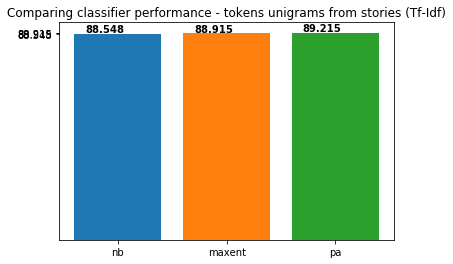

In [22]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

clf_types = ['nb', 'maxent', 'pa']
xs = np.arange(len(clf_types))
ys = [round(v*100,3) for v in cv_scores]

fig = plt.figure()                                                               
ax = fig.gca()  #get current axes
ax.bar(xs, ys, width=0.8, align='center', color=mcolors.TABLEAU_COLORS) #['blue', 'green', 'red'])
# Add score on to of each bar
for i, v in enumerate(ys):
    ax.text(i-.3,v+.7, str(v), color='black', fontweight='bold')
ax.set_xticks(xs)
#Replace the tick numbers with strings:
ax.set_xticklabels(clf_types)
ax.set_yticks(ys)
ax.set_title( 'Comparing classifier performance - tokens unigrams from stories (Tf-Idf)' )

### Exercise 3.4: Comparing different feature sets - Tokens from the stories

Finally, we're going to compare various feature sets. This exercise is split into several cells to make it easier to read. 

For each feature set, try to update the following lists:
    - *feature_types*: list of names representing the features (e.g. 'tok' for tokens, 'tok_sw' for tokens without stop words etc)
    - *cv_scores_feats*: list containing the best macro-averaged F1 score obtained during tuning 

First, we're going to play a bit more with the stories. We already have unigrams features normalized with TF-IDF.

1. Check the 20 best features for each class with unigrams + TF-IDF and the classifier **clf_me**
    * more precisely, you need to use the estimator that has been refit on the whole training set at the end of the tuning procedure (note: *GridSearchCV* objects have a parameter *refit* set to True by default), ie:
```
best_clf = clf_me.best_estimator_ 
```


In [23]:
feature_types, cv_scores_feats = [], []
feature_types.append('tok')
cv_scores_feats.append( clf_me.best_score_ )

# 1. Look at the best features
best_clf = clf_me.best_estimator_ 
vocab = my_vectorizer.vocabulary_
print( 'Vocab size:', len(vocab) )

ix_to_tag = { v:k for k,v in tag_to_ix.items() }
ix_to_tokens = { v:k for k,v in vocab.items() }

# clf.coef_ contains the weights of each features after training
# - Save the weights in a dict key = index, value = weight
features_weights = {i:w for (i,w) in enumerate( best_clf.coef_[0] ) }

# - Extract a sorted list (index,weight) sorte by weight (increasing order)
sorted_weights = [(i,w) for (i,w) in sorted(features_weights.items(), key=lambda kv: kv[1])]

# - Look at the first 10 weights and corr tokens = best feat for class 0
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[:20]] ) )

print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[-20:]] ) )

Vocab size: 17707

Best features for identifying class 0, ie Comedy
comedy:-10.876959663161438
get:-8.582785174275298
no:-7.962746638128581
frank:-7.715854165364013
wedding:-7.595474852449011
park:-6.98254766907795
adventure:-6.801485739906886
hero:-6.678516235945645
along:-6.612561144112354
agent:-6.321997777473598
trip:-6.293545888027697
fall:-6.25225896213683
girlfriend:-6.244148326993353
magic:-6.2366128370082805
after:-6.151934554869415
scott:-5.913685944659353
always:-5.904279729133943
friends:-5.871926394956065
must:-5.850247903240921
rapunzel:-5.822859372827464

Best features for identifying class 1, ie Drama
starts:4.1758232530731405
memories:4.221443778143537
face:4.256921535755344
against:4.405974193070842
troubled:4.419908814077405
community:4.63582773333796
sean:4.686372555124975
apart:4.733058403085804
under:4.737016574004283
will:4.869942676561267
system:4.952986507755327
hospital:5.014905301358745
story:5.05294903210031
its:5.1920174844474385
years:5.221802689405205
in:

### Exercise 3.4 (suite): Stop words

2. Re-run everything (vectorize, tune, evaluate and print best features) using the *stop_word='English'* parameter of the object *CountVectorize* to remove function words. Call the new vectorizer **my_vectorizer_sw**.

In [24]:
# 2.A. Vectorize into X_train and X_test using raw counts + stop_words='English' +  TF-IDF normalization
my_vectorizer_sw = CountVectorizer( stop_words='english' )
X_train = my_vectorizer_sw.fit_transform(train_story)
X_test = my_vectorizer_sw.transform(test_story)
my_transformer_sw = TfidfTransformer()
X_train = my_transformer_sw.fit_transform(X_train)
X_test = my_transformer_sw.transform(X_test)

# 2.B. Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train.shape)
print('Test:', X_test.shape)
print( "Vocabulary size:", len(my_vectorizer_sw.vocabulary_) )

clf_me = GridSearchCV( estimator=LogisticRegression(), 
                   param_grid=param_grid_me,
                   scoring='accuracy',
                   cv=5
                  )

# 2.C. Start the search over the hyper-parameters by calling the fit function over X_train
# Predict and print final scores
clf_me.fit( X_train, y_train )
y_pred = clf_me.predict( X_test )
print( classification_report(y_test, y_pred) )

# 2.D. Print the best features
best_clf = clf_me.best_estimator_ 
vocab = my_vectorizer_sw.vocabulary_
print( 'Vocab size:', len(vocab) )

ix_to_tag = { v:k for k,v in tag_to_ix.items() }
ix_to_tokens = { v:k for k,v in vocab.items() }

# clf.coef_ contains the weights of each features after training
# - Save the weights in a dict key = index, value = weight
features_weights = {i:w for (i,w) in enumerate( best_clf.coef_[0] ) }

# - Extract a sorted list (index,weight) sorte by weight (increasing order)
sorted_weights = [(i,w) for (i,w) in sorted(features_weights.items(), key=lambda kv: kv[1])]

# - Look at the first 10 weights and corr tokens = best feat for class 0
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[:20]] ) )

print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[-20:]] ) )


feature_types.append('tok_sw')
cv_scores_feats.append( clf_me.best_score_ )

Train: (2995, 17422)
Test: (749, 17422)
Vocabulary size: 17422
              precision    recall  f1-score   support

           0       0.97      0.82      0.88       357
           1       0.85      0.97      0.91       392

    accuracy                           0.90       749
   macro avg       0.91      0.89      0.90       749
weighted avg       0.91      0.90      0.90       749

Vocab size: 17422

Best features for identifying class 0, ie Comedy
comedy:-10.586890239440784
adventure:-7.420220000544807
wedding:-7.170379637992707
frank:-7.154038541900925
hero:-7.136301320014718
agent:-6.884795272399455
girlfriend:-6.770667656742047
save:-6.541985273284109
magic:-6.451295223977679
park:-6.4191254614356765
trip:-6.396427134761875
friends:-6.3561345116265455
scott:-6.200839498380759
married:-6.051244267401398
mr:-6.015840496666144
way:-5.75821859217948
rapunzel:-5.705957874213191
thing:-5.684333096585299
guys:-5.600017184040869
christmas:-5.594183223941694

Best features for identify

### Exercise 3.4 (suite): Nouns and verbs

3. Use postags to investigate the use of nouns and verbs as features
    1. Extract nouns as a string for each story in the test and train set (e.g. the POS starts with 'N')
    2. Extract verbs as a string for each story in the test and train set (e.g. the POS starts with 'V')
    3. Vectorize the data, print the vocabulary sizes
    4. Tune and evaluate models using MaxEnt 
    5. Look at the best verb features

In [25]:
# postags is a dictionnary: movie id --> list of triplets (token, lemma, pos)
postags = read_postags( path_to_postags_filtered )

# We add the information from postags files to the movies dictionnary at the key 'tok_lem_pos'
merge_movies( movies, postags )
print( movies[0], '\n' )

# 3.A. Extract nouns from the stories
train_story_nouns = [ ' '.join([tok for (tok,lem,pos) in m['tok_lem_pos'] if pos.startswith('N')]) for m in train ]

test_story_nouns = [ ' '.join([tok for (tok,lem,pos) in m['tok_lem_pos'] if pos.startswith('N')]) for m in test ]
# check
print( train[0]['tok_lem_pos'])
print( train_story_nouns[0] )

# 3.B. Extract nouns from the stories
train_story_verbs = [ ' '.join([tok for (tok,lem,pos) in m['tok_lem_pos'] if pos.startswith('V')]) for m in train ]

test_story_verbs = [ ' '.join([tok for (tok,lem,pos) in m['tok_lem_pos'] if pos.startswith('V')]) for m in test ]
# check
print( train[0]['tok_lem_pos'])
print( train_story_nouns[0] )


# 3.C. Vectorize
my_vectorizer_n = CountVectorizer()
X_train_nouns  = my_vectorizer_n.fit_transform( train_story_nouns )
X_test_nouns = my_vectorizer_n.transform( test_story_nouns )
print( "Vocabulary size nouns:", len(my_vectorizer_n.vocabulary_) )

my_vectorizer_v = CountVectorizer()
X_train_verbs = my_vectorizer_v.fit_transform( train_story_verbs )
X_test_verbs = my_vectorizer_v.transform( test_story_verbs )
print( "Vocabulary size verbs:", len(my_vectorizer_v.vocabulary_) )

# 3.D. Start the search over the hyper-parameters by calling the fit function over X_train
print('\nScores for nouns')
clf_me_n = GridSearchCV( estimator=LogisticRegression(), 
                   param_grid=param_grid_me,
                   scoring='accuracy',
                   cv=5
                  )
clf_me_n.fit( X_train_nouns, y_train )

# Predict and print final scores
y_pred = clf_me_n.predict( X_test_nouns )
print( classification_report(y_test, y_pred) )

print('\nScores for verbs')
clf_me_v = GridSearchCV( estimator=LogisticRegression(), 
                   param_grid=param_grid_me,
                   scoring='accuracy',
                   cv=5
                  )
clf_me_v.fit( X_train_verbs, y_train )

# Predict and print final scores
y_pred = clf_me_v.predict( X_test_verbs )
print( classification_report(y_test, y_pred) )

# 3.E. Print the best features
best_clf_v = clf_me_v.best_estimator_ 
vocab = my_vectorizer_v.vocabulary_
print( 'Vocab size (verbs):', len(vocab) )

ix_to_tag = { v:k for k,v in tag_to_ix.items() }
ix_to_tokens = { v:k for k,v in vocab.items() }

# clf.coef_ contains the weights of each features after training
# - Save the weights in a dict key = index, value = weight
features_weights = {i:w for (i,w) in enumerate( best_clf_v.coef_[0] ) }

# - Extract a sorted list (index,weight) sorte by weight (increasing order)
sorted_weights = [(i,w) for (i,w) in sorted(features_weights.items(), key=lambda kv: kv[1])]

# - Look at the first 10 weights and corr tokens = best feat for class 0
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[:20]] ) )

print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[-20:]] ) )

feature_types.append('nouns')
cv_scores_feats.append( clf_me_n.best_score_ )

feature_types.append('verbs')
cv_scores_feats.append( clf_me_v.best_score_ )

{'identifier': 'tt0816692', 'title': 'Interstellar', 'year': 2014, 'director': 'Christopher Nolan', 'story': "Earth's future has been riddled by disasters, famines, and droughts. There is only one way to ensure mankind's survival: Interstellar travel. A newly discovered wormhole in the far reaches of our solar system allows a team of astronauts to go where no man has gone before, a planet that may have the right environment to sustain human life.", 'actors': ['Matthew_McConaughey', 'Anne_Hathaway', 'Jessica_Chastain'], 'genres': ['Adventure', 'Drama', 'Sci-Fi'], 'countries': ['USA', 'UK', 'Canada'], 'rating': 8.6, 'voters': 1322406, 'gross': 47510, 'tok_lem_pos': [('earths', 'earths', 'JJ'), ('future', 'future', 'NN'), ('has', 'have', 'VBZ'), ('been', 'be', 'VBN'), ('riddled', 'riddle', 'VBN'), ('by', 'by', 'IN'), ('disasters', 'disaster', 'NNS'), ('famines', 'famine', 'NNS'), ('and', 'and', 'CC'), ('droughts', 'drought', 'NNS'), ('there', 'there', 'EX'), ('is', 'be', 'VBZ'), ('only', 

### Exercice 3.4 (suite): bi-grams

4. Try with bi-grams:
    1. Vectorize the stories to generate bigrams: using *ngram_range=(2,2)* as a parameter of your *Vectorizer* object will automatically create bi-grams features of your input data (i.e. pairs of adjacent words). 
    2. Print the shape of the matrices: It's a lot of features!
    3. Tune and evaluate a MaxEnt model
    4. Print the best features

You don't have to try it now, but note that if you use *ngram_range=(1,2)*, it will create both unigrams and bigrams.

In [26]:
# 4.A. Vectorize into X_train and X_test using raw counts + stop_words='English' + bigrams +  TF-IDF normalization
my_vectorizer_bi = CountVectorizer( stop_words='english', ngram_range=(2,2) )
X_train = my_vectorizer_bi.fit_transform(train_story)
X_test = my_vectorizer_bi.transform(test_story)
my_transformer_bi = TfidfTransformer()
X_train = my_transformer_bi.fit_transform(X_train)
X_test = my_transformer_bi.transform(X_test)

# 2.B. Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train.shape)
print('Test:', X_test.shape)
print( "Vocabulary size:", len(my_vectorizer_bi.vocabulary_) )

# 2.C. Start the search over the hyper-parameters by calling the fit function over X_train
clf_me = GridSearchCV( estimator=LogisticRegression(), 
                   param_grid=param_grid_me,
                   scoring='accuracy',
                   cv=5
                  )
clf_me.fit( X_train, y_train )

# Predict and print final scores
y_pred = clf_me.predict( X_test )
print( classification_report(y_test, y_pred) )

# 2.D. Print the best features
best_clf = clf_me.best_estimator_ 
vocab = my_vectorizer_bi.vocabulary_
print( 'Vocab size:', len(vocab) )

ix_to_tag = { v:k for k,v in tag_to_ix.items() }
ix_to_tokens = { v:k for k,v in vocab.items() }

# clf.coef_ contains the weights of each features after training
# - Save the weights in a dict key = index, value = weight
features_weights = {i:w for (i,w) in enumerate( best_clf.coef_[0] ) }

# - Extract a sorted list (index,weight) sorte by weight (increasing order)
sorted_weights = [(i,w) for (i,w) in sorted(features_weights.items(), key=lambda kv: kv[1])]

# - Look at the first 10 weights and corr tokens = best feat for class 0
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[:20]] ) )

print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[-20:]] ) )

feature_types.append('bigr')
cv_scores_feats.append( clf_me.best_score_ )

Train: (2995, 79408)
Test: (749, 79408)
Vocabulary size: 79408


/home/cbraud/anaconda3/envs/l7-preprocess/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.88      0.79      0.83       357
           1       0.82      0.90      0.86       392

    accuracy                           0.85       749
   macro avg       0.85      0.85      0.85       749
weighted avg       0.85      0.85      0.85       749

Vocab size: 79408

Best features for identifying class 0, ie Comedy
seth rogen:-40.276073814686846
successful hollywood:-38.62105487762902
save world:-36.69068488057055
trail leads:-32.92730418938767
unlock real:-31.879097039673724
epic journey:-29.993460717290525
justin timberlake:-28.70983547581536
40 year:-28.52187635345578
manages convince:-27.48051313583503
collinwood manor:-27.293257665561214
romantic comedy:-26.672206306808228
goes awry:-26.007284282505957
hidden beneath:-25.465105648136287
evil wizard:-25.405166804588983
good guy:-24.55055015128313
mother gothel:-24.351595293957597
wade wilson:-21.347583517948184
save galaxy:-20.786869088131674
growing mutu

### Exercise 3.5: Comparing different feature sets - Combining features

1. Extract actor names for each sets of data
2. Run a classifier to get performance with this set of features

In [27]:
# 1. Given: Extract the actors from the train and test lists into  train_actor, test_actor
train_actor = [' '.join( m['actors'] ) for m in train]
test_actor = [' '.join( m['actors'] ) for m in test]

# 2. Vectorize into X_train_act and X_test_act using raw counts +  TF-IDF normalization
my_vectorizer_act = CountVectorizer( stop_words='english' )
X_train_act = my_vectorizer_act.fit_transform(train_actor)
X_test_act = my_vectorizer_act.transform(test_actor)
my_transformer_act = TfidfTransformer()
X_train_act = my_transformer_act.fit_transform(X_train_act)
X_test_act = my_transformer_act.transform(X_test_act)

# 2.B. Print the shape of the matrices X_train and X_test and the size of the vocabulary
print('Train:', X_train_act.shape)
print('Test:', X_test_act.shape)
print( "Vocabulary size:", len(my_vectorizer_act.vocabulary_) )

clf_me = GridSearchCV( estimator=LogisticRegression(), 
                   param_grid=param_grid_me,
                   scoring='accuracy',
                   cv=5
                  )

# 2.C. Start the search over the hyper-parameters by calling the fit function over X_train
# Predict and print final scores
clf_me.fit( X_train_act, y_train )
y_pred_act = clf_me.predict( X_test_act )
print( classification_report(y_test, y_pred_act) )

# 2.D. Print the best features
best_clf = clf_me.best_estimator_ 
vocab_act = my_vectorizer_act.vocabulary_
print( 'Vocab size:', len(vocab_act) )

ix_to_tag = { v:k for k,v in tag_to_ix.items() }
ix_to_tokens = { v:k for k,v in vocab_act.items() }

# clf.coef_ contains the weights of each features after training
# - Save the weights in a dict key = index, value = weight
features_weights = {i:w for (i,w) in enumerate( best_clf.coef_[0] ) }

# - Extract a sorted list (index,weight) sorte by weight (increasing order)
sorted_weights = [(i,w) for (i,w) in sorted(features_weights.items(), key=lambda kv: kv[1])]

# - Look at the first 10 weights and corr tokens = best feat for class 0
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[:20]] ) )

print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[-20:]] ) )


feature_types.append('actor')
cv_scores_feats.append( clf_me.best_score_ )

Train: (2995, 3653)
Test: (749, 3653)
Vocabulary size: 3653


/home/cbraud/anaconda3/envs/l7-preprocess/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.91      0.81      0.86       357
           1       0.84      0.92      0.88       392

    accuracy                           0.87       749
   macro avg       0.87      0.87      0.87       749
weighted avg       0.87      0.87      0.87       749

Vocab size: 3653

Best features for identifying class 0, ie Comedy
angourie_rice:-5.453332129555939
seth_rogen:-5.435776563298671
seth_macfarlane:-5.225894956888777
nick_frost:-5.213112335684858
kevin_hart:-5.164821954892081
zach_galifianakis:-5.110977007251117
owen_wilson:-5.0833813426347625
taron_egerton:-5.074222223001874
jason_bateman:-5.04462514691988
ice_cube:-4.998437303032262
jason_sudeikis:-4.83474640354674
jack_black:-4.607386210792836
tim_allen:-4.603935534251383
paul_rudd:-4.601741108231039
billy_crystal:-4.477805499789468
chris_pratt:-4.426132860431486
john_c_reilly:-4.387820047519436
will_ferrell:-4.2620362853466895
jay_baruchel:-4.202046434518412
kri

### Exercise 3.5 (suite): combine stories and actors

3. Combine token unigrams and actor names 

##### First solution: expanding textual information

* Create a list of instance containing both information:
```
>>> ['One upon a time, in a small little town', ['andy_samberg','anna_kendrick']]
'One upon a time, in a small little town andy_samberg anna_kendrick'
```
To keep track of where the features come from, they can be transformed:
```
>>> ['One upon a time, in a small little town', ['andy_samberg','anna_kendrick']]
'story__One story__upon story__a story__time story__in story__a story__small story__little story_town actor__andy_samberg actor__anna_kendrick'
```

##### Second solution: stacking matrices
* Vectorize data from stories in the matrix *X_stories*
* Vectorize data from actors in the matrix *X_actors*
* Stack them:
```
>>> print( X_stories.shape )
(,)
>>> print( X_actors.shape )
(,)
>>> X= scipy.sparse.hstack( [X_stories, X_actors] )
>>> print( X.shape )
(,)
```
* You also need to modify the vocabulary:
```
vocab = vocab_stories.copy()
for w,ix in vocab_actors:
    w = 'actors__'+w #Make sure you don t have doublons
    if not w in vocab:
        vocab[w] = len(vocab)
```


In [28]:
from scipy import sparse

# 3.A. Vectorize into X_train and X_test using raw counts + stop_words='English' +  TF-IDF normalization
# We already have X_train_act, X_test_act, my_vectorizer_act
my_vectorizer_st = CountVectorizer( stop_words='english' )
X_train_st = my_vectorizer_st.fit_transform(train_story)
X_test_st = my_vectorizer_st.transform(test_story)
my_transformer_st = TfidfTransformer()
X_train_st = my_transformer_st.fit_transform(X_train_st)
X_test_st = my_transformer_st.transform(X_test_st)

print( 'Train story:', X_train_st.shape, 'Train actor:', X_train_act.shape )

# 3.B. Stack
X_train = sparse.hstack([X_train_st, X_train_act])
X_test = sparse.hstack([X_test_st, X_test_act])
print( 'Train:', X_train.shape, 'Test:', X_test.shape )

# 3.C. Modify the vocabulary
vocab = my_vectorizer_st.vocabulary_.copy()
for w,ix in my_vectorizer_act.vocabulary_.items():
    w = 'actors__'+w #Make sure you don t have doublons
    if not w in vocab:
        vocab[w] = len(vocab)
print('Vocab size:', len(vocab))

# 3.D. Tune, test, look at the best features
clf_me = GridSearchCV( estimator=LogisticRegression(), 
                   param_grid=param_grid_me,
                   scoring='accuracy',
                   cv=5
                  )

# Start the search over the hyper-parameters by calling the fit function over X_train
# Predict and print final scores
clf_me.fit( X_train, y_train )
y_pred = clf_me.predict( X_test )
print( classification_report(y_test, y_pred) )

# 2.D. Print the best features
best_clf = clf_me.best_estimator_ 

ix_to_tag = { v:k for k,v in tag_to_ix.items() }
ix_to_tokens = { v:k for k,v in vocab.items() }

# clf.coef_ contains the weights of each features after training
# - Save the weights in a dict key = index, value = weight
features_weights = {i:w for (i,w) in enumerate( best_clf.coef_[0] ) }

# - Extract a sorted list (index,weight) sorte by weight (increasing order)
sorted_weights = [(i,w) for (i,w) in sorted(features_weights.items(), key=lambda kv: kv[1])]

# - Look at the first 20 weights and corr tokens = best feat for class 0
print( '\nBest features for identifying class 0, ie', ix_to_tag[0])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[:20]] ) )

print( '\nBest features for identifying class 1, ie', ix_to_tag[1])
print( '\n'.join( [':'.join( (ix_to_tokens[i],str(w)) ) 
                   for (i,w) in sorted_weights[-20:]] ) )

feature_types.append('tok_sw+actor')
cv_scores_feats.append( clf_me.best_score_ )

Train story: (2995, 17422) Train actor: (2995, 3653)
Train: (2995, 21075) Test: (749, 21075)
Vocab size: 21075
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       357
           1       0.85      0.96      0.90       392

    accuracy                           0.89       749
   macro avg       0.90      0.89      0.89       749
weighted avg       0.90      0.89      0.89       749


Best features for identifying class 0, ie Comedy
comedy:-6.947646883932019
actors__yûko_miyamura:-5.752484098331827
actors__connell:-5.5595412703119775
actors__bennu_yildirimlar:-5.392749501808271
wedding:-5.371215314072083
actors__robert_patrick:-5.306282572303953
actors__james_buckley:-5.214521358053664
actors__omar_chaparro:-5.190428674361335
actors__sande:-5.189776657949391
actors__katerina_misichroni:-5.18270468996077
friends:-4.987343850888918
actors__laura_smet:-4.887246829482439
frank:-4.812654086606491
adventure:-4.810158306136344
actors__zana_ma

**Results:**
* Without going into details, at least we can say that having the word 'comedy' as a good indicator of a Comedy is comforting :) But having such strong signal can also be bad for a model that won't even try to learn more subtle indicators.
* Some features are interesting: comedies are more about adventures ('save world', 'epic journey') while drama are linked to expected key words such as 'war' and 'hospital', but also 'school teacher' and 'young girl'. Using more data could help identify more specific trends.

In [29]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

#feature_types, cv_scores_feats = [], []
xs = np.arange(len(feature_types))
ys = [round(v*100,3) for v in cv_scores_feats]

print( 'Number of feature sets tested:', len(feature_types))

fig = plt.figure()                                                               
ax = fig.gca()  #get current axes
ax.bar(xs, ys, width=0.8, align='center', color=mcolors.TABLEAU_COLORS) # ['blue', 'green', 'red', 'black', 'grey'])
# Add score on to of each bar
for i, v in enumerate(ys):
    ax.text(i-.3,v+.7, str(v), color='black', fontweight='bold')
ax.set_xticks(xs)
#Replace the tick numbers with strings:
ax.set_xticklabels(feature_types)
ax.set_yticks(ys)
ax.set_title( 'Comparing classifier performance using various feature sets (MaxEnt, macro F1)' )

Number of feature sets tested: 7


Text(0.5, 1.0, 'Comparing classifier performance using various feature sets (MaxEnt, macro F1)')

## Part 4: Conclusion

We're done, we saw how to vectorize our data, to use a classifier, how to fit it on a training set, to tune the hyper-parameters via cross-validation, to make predictions on new data and evaluate the results. 

To go further:
* Evaluation metrics: the classification report is nice, because it gives various metrics. Take a close look to your results, to understand the behavior of the various scores. Our medels have good performance, but the performance are especially good for one class (which one?). Print the confusion matrix to get a better understanding of your classifiers. You can also investigate errors by looking at examples incorrectly predicted.
* Balanced data: the filtering method gave us a balanced dataset (equal number of instances for each class). You can try to regenerate the dataset without the balancing option. What happen to the performance?
* Binary vs multi-class: try to add action movies and to perform multi-class classification!
* Use the gross income to play with regression!
* You can also use the data with all genres and play with clustering!